# PCA_ClusterAnalysis
Andrew E. Davidson  
aedavids@ucsc.edu  
8/29/24  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0  

The elife data does not cluster. Reducing data set to 712 biomarkers from /private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/model does not cluster

ref:
- extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/lungCancerPCA_ClusterAnalysis.ipynb
shape : (224,7655), MinMaxScaler()
- extraCellularRNA/deconvolutionAnalysis/jupyterNotebooks/randomForestGeneSignatureDeconvolution.ipynb
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- https://scikit-plot.readthedocs.io/en/stable/decomposition.html#scikitplot.decomposition.plot_pca_2d_projection

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display
import joblib
import logging
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
# display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# from sklearn.metrics import confusion_matrix
# from sklearn.ensemble      import RandomForestClassifier
# from sklearn.preprocessing import LabelEncoder

# from sklearn.metrics         import recall_score
# from sklearn.metrics         import roc_auc_score
# from sklearn.metrics         import make_scorer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler #, StandardScaler # LabelEncoder, 

import sys
import umap

/data/tmp/ipykernel_714127/1028271887.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/private/home/aedavids/miniconda3/envs/extraCellularRNA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

outDir = f'{notebookDir}/{notebookName}.out'
#outDir = f'/private/groups/kimlab/aedavids/deconvolution/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

localCacheDir = "/scratch/aedavids/" + notebookName + "/cache"
print(f'\nlocalCacheDir :\n{localCacheDir}')


loglevel = "INFO"
#loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

pipelineStageName = "best10CuratedDegree1_ce467ff"

outDir:
/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/gan/clusterAnalysis.out

modelOutDir ;
/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/gan/clusterAnalysis.out/model

imgOut :
/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/gan/clusterAnalysis.out/img

localCacheDir :
/scratch/aedavids/clusterAnalysis/cache


In [3]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = os.environ['PYTHONPATH']
print("ORIG_PYTHONPATH: {}\n".format(PYTHONPATH))

gitRepoRoot = !git rev-parse --show-toplevel
gitRepoRoot = gitRepoRoot[0]

#
# add deconvolutionAnalysis modules
#
deconvolutionModules = f'{gitRepoRoot}/deconvolutionAnalysis/python'
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = PYTHONPATH + f':{deconvolutionModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(deconvolutionModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

#
# add intraExtraRNA_POC modules
#
intraExtraRNA_POCModules = f'{gitRepoRoot}/intraExtraRNA_POC/python/src'
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(intraExtraRNA_POCModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

ORIG_PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src

deconvolutionModules: /private/home/aedavids/extraCellularRNA/deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/python/src



In [4]:
# local imports
from analysis.utilities import loadList
from intraExtraRNA.plasmaGAN.plasmaGAN import loadCountData

## Find features used to train randomForestGeneSignatureDeconvolution model
This model was trained on  GTEx_TCGA training data set has perfect TP!

ref: deconvolutionAnalysis/jupyterNotebooks/randomForestGeneSignatureDeconvolution

model saved to /private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out

best10CuratedDegree1_ce467ff_elife.orderedFeatures.txt has the list of features. The "elife" token in the file name is a little confusing. The CIBERSORTx signature matrix for best10CuratedDegree1_ce467ff has a couple of gene that we could not map to the elife data set. This list of features is the elife subset of features

In [5]:
def getListOfFeatures() :
    '''
    wrapper function to prevent global namespace polution
    '''
    rfPath = "/private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/model"
    fileName = "best10CuratedDegree1_ce467ff_elife.orderedFeatures.txt"
    p = rfPath + "/" + fileName
    print(f'loading features:\n{p}' )
    ret = loadList( p )

    return ret

HUGO_featuresNames = getListOfFeatures()

print(f'\nnumber of HUGO_featuresNames : {len(HUGO_featuresNames)}')
print( f'first 3: {HUGO_featuresNames[:3]} last 3: {HUGO_featuresNames[-3:]}' )

loading features:
/private/groups/kimlab/aedavids/deconvolution/randomForestGeneSignatureDeconvolution.out/model/best10CuratedDegree1_ce467ff_elife.orderedFeatures.txt

number of HUGO_featuresNames : 712
first 3: ['(GGTG)n', '(GT)n', '(TA)n'] last 3: ['ZRANB1', 'ZSWIM4', 'ZYG11B']


# Load Gene Expression Data

In [6]:
%%time
# from intraExtraRNA.plasmaGAN.plasmaGAN import loadCountData

# localCacheDir = "/scratch/aedavids/" + notebookName + "/cache"
XDF, metaDF, elifeLungGenes, missingElifeGenes, mapDF = loadCountData( localCacheDir, HUGO_featuresNames )

print( f'XDF.shape : {XDF.shape}' )
print( XDF.iloc[0:5, 0:3] )

assert len(missingElifeGenes) == 0,"ERROR"

2024-10-10 12:21:32,871 INFO intraExtraRNA.plasmaGAN.plasmaGAN loadCountData() line:55] [BEGIN]
2024-10-10 12:21:32,872 INFO intraExtraRNA.plasmaGAN.plasmaGAN loadCountData() line:74] [loading from /scratch/aedavids/clusterAnalysis/cache]
2024-10-10 12:21:32,954 INFO intraExtraRNA.plasmaGAN.plasmaGAN loadCountData() line:104] [END]


XDF.shape : (224, 712)
             ENSG00000198744.5  ENSG00000187642.9  ENSG00000215915.10
sampleId                                                             
SRR14506659          12.410588           3.102647            0.000000
SRR14506660           3.473295           0.000000            2.083977
SRR14506661           0.000000           0.000000            0.000000
SRR14506662           8.203563           0.000000            0.000000
SRR14506663           0.000000          40.983492           66.354226
CPU times: user 81.1 ms, sys: 7.87 ms, total: 88.9 ms
Wall time: 88 ms


## PCA

In [7]:
XNP = XDF.values
XScaledNP = MinMaxScaler().fit_transform(XNP)

pca = PCA(n_components=2, random_state=42)
principalComponentsNP = pca.fit_transform(XScaledNP)

In [8]:
metaDF.head()

,Unnamed: 0,sample_id,diagnosis
0,0,SRR14506659,Esophagus Cancer
1,1,SRR14506660,Esophagus Cancer
2,2,SRR14506661,Esophagus Cancer
3,3,SRR14506662,Esophagus Cancer
4,4,SRR14506663,Esophagus Cancer


xmin: -0.6147508371054918 xMax : 16.30867571282514
yMin: -1.4389041676837646 yMax : 1.5358750173163047
df.shape : (224, 3)
saved image to /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/gan/clusterAnalysis.out/img/PCA.png


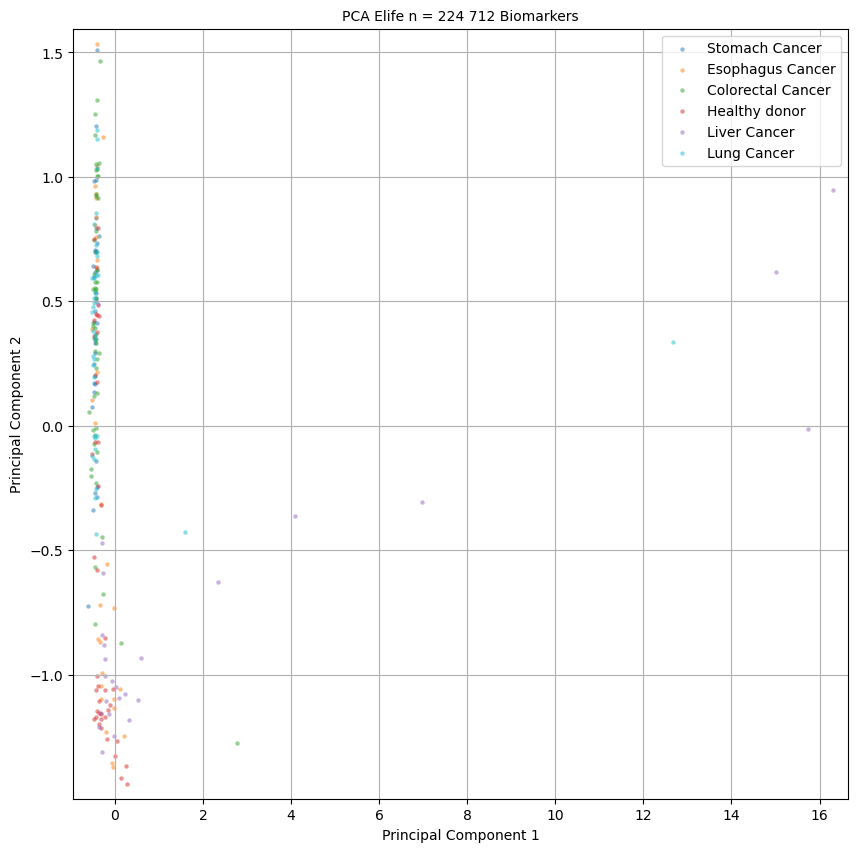

In [9]:
from plots.scatterPlots import createScatterPlot

def plotPCA(principalComponentsNP, XDF, metaDF):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']
    fig, pannel = createScatterPlot(
        x = principalComponentsNP[:,0],
        y = principalComponentsNP[:,1],
    
        title = f'PCA Elife n = {principalComponentsNP.shape[0]} {len(XDF.columns)} Biomarkers',
        xLabel = 'Principal Component 1',
        yLabel = 'Principal Component 2', 
        categories = metaDF.loc[:, "diagnosis"].values,
        # colors  = ['r',  'b'],
        colors = colors,
        #figSize = (4,4), 
        figSize = (10,10), 
        axisPaddingPrecentage = 0.02,
    )

    imgFilePath = imgOut + "/PCA.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotPCA( principalComponentsNP, XDF, metaDF )

## UMAP

In [10]:
%%time
reducer = umap.UMAP()
UMAPEmbeddingNP = reducer.fit_transform(XScaledNP)
print(f'UMAPEmbeddingNP.shape : {UMAPEmbeddingNP.shape}')

UMAPEmbeddingNP.shape : (224, 2)
CPU times: user 44.6 s, sys: 4.31 s, total: 48.9 s
Wall time: 11.4 s


xmin: 1.2631340026855469 xMax : 7.1604437828063965
yMin: 2.0814387798309326 yMax : 9.318990707397461
df.shape : (224, 3)
saved image to /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/gan/clusterAnalysis.out/img/UMAP.png


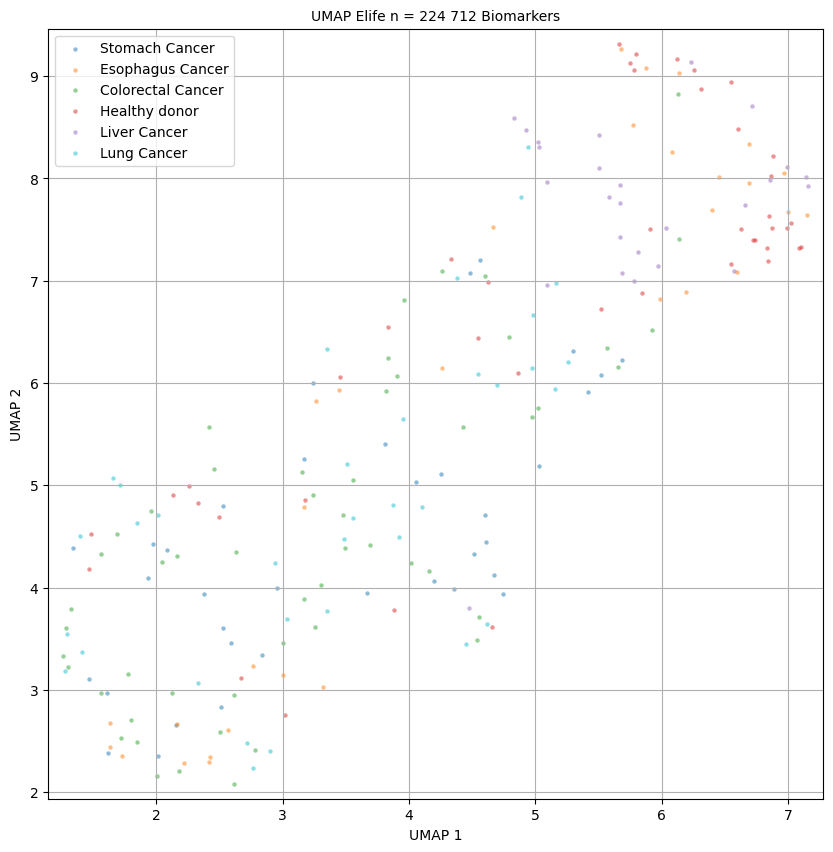

In [11]:
def plotUMAP(UMAPEmbeddingNP, XDF, metaDF) :
    '''
    TODO
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']


    fig, pannel = createScatterPlot(
        x = UMAPEmbeddingNP[:,0],
        y = UMAPEmbeddingNP[:,1],
        title = f'UMAP Elife n = {UMAPEmbeddingNP.shape[0]} {len(XDF.columns)} Biomarkers',
        xLabel = 'UMAP 1',
        yLabel = 'UMAP 2', 
        categories = metaDF.loc[:, "diagnosis"].values,
        # colors  = ['r',  'b'],
        colors = colors,
        #figSize = (4,4), 
        figSize = (10,10), 
        #figSize = (15,15), 
        axisPaddingPrecentage = 0.02,
        #axisPaddingPrecentage = -0.01, # may clip some outliers
    )
    
    imgFilePath = imgOut + "/UMAP.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotUMAP(UMAPEmbeddingNP, XDF, metaDF)

## TSNE

In [12]:
%%time
TSNE_embedded = TSNE().fit_transform(XScaledNP)

CPU times: user 11min 58s, sys: 2.81 s, total: 12min 1s
Wall time: 16.1 s


xmin: -12.262572288513184 xMax : 11.515206336975098
yMin: -7.472996711730957 yMax : 8.21910285949707
df.shape : (224, 3)
saved image to /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/gan/clusterAnalysis.out/img/TSNE.png


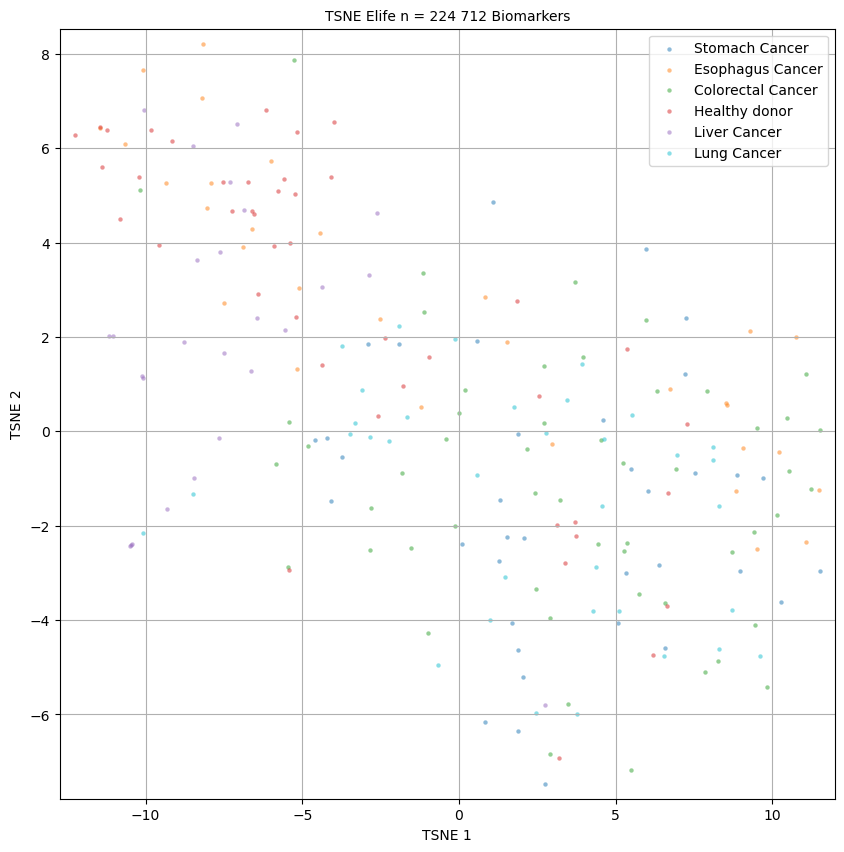

In [13]:
def plotTSNE(TSNE_embedded, XDF, metaDF) :
    '''
    TODO
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']


    fig, pannel = createScatterPlot(
        x = TSNE_embedded[:,0],
        y = TSNE_embedded[:,1],
        title = f'TSNE Elife n = {TSNE_embedded.shape[0]} {len(XDF.columns)} Biomarkers',
        xLabel = 'TSNE 1',
        yLabel = 'TSNE 2', 
        categories = metaDF.loc[:, "diagnosis"].values,
        # colors  = ['r',  'b'],
        colors = colors,
        #figSize = (4,4), 
        figSize = (10,10), 
        #figSize = (15,15), 
        axisPaddingPrecentage = 0.02,
        #axisPaddingPrecentage = -0.01, # may clip some outliers
    )
    
    imgFilePath = imgOut + "/TSNE.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotTSNE(TSNE_embedded, XDF, metaDF)